In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math

# Mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [135]:
# Cargamos dataset
file_path = "./datasets/clean_listings.csv"
airbnb_df = pd.read_csv(file_path)

## Visualización

### 1. Feature engineering

In [136]:
df_fe = airbnb_df.copy()

Codificación y discretización

In [137]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# neighbourhood
neighbourhood_categories = sorted(df_fe["neighbourhood_cleansed"].unique())
ordinal_encoder = OrdinalEncoder(categories=[neighbourhood_categories])
df_fe["neighbourhood_encoded"] = ordinal_encoder.fit_transform(df_fe[["neighbourhood_cleansed"]]).astype(int)
df_fe.head(10)

# room_type
room_type_categories = sorted(df_fe["room_type"].unique())
ordinal_encoder = OrdinalEncoder(categories=[room_type_categories])
df_fe["room_type_encoded"] = ordinal_encoder.fit_transform(df_fe[["room_type"]]).astype(int)
df_fe.head(10)

# property_type
property_type_categories = sorted(df_fe["property_type"].unique())
ordinal_encoder = OrdinalEncoder(categories=[property_type_categories])
df_fe["property_type_encoded"] = ordinal_encoder.fit_transform(df_fe[["property_type"]]).astype(int)

# Discretizar
df_fe['reviews_bin'] = pd.qcut(df_fe['number_of_reviews'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy alto'])

df_fe.head(10)

,host_id,price,room_type,property_type,neighbourhood_cleansed,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month,instant_bookable,missing_count,neighbourhood_encoded,room_type_encoded,property_type_encoded,reviews_bin
0,191042082,36758.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,3.0,3,1125,73,15,4.67,4.67,5.00,5.00,5.00,0.20,False,0,0,0,16,Alto
1,137427072,37000.0,Entire home/apt,Entire rental unit,Agronomia,3,0.0,2.0,3,180,179,15,4.93,4.73,4.80,4.93,4.80,0.22,False,0,0,0,16,Alto
2,385856273,28356.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,1.0,2,1125,328,67,4.87,4.73,4.93,4.97,4.88,1.39,False,0,0,0,16,Muy alto
3,895346,74475.0,Entire home/apt,Entire rental unit,Agronomia,4,2.0,3.0,3,27,168,17,4.82,4.94,4.94,4.88,4.82,0.47,False,0,0,0,16,Alto
4,225695530,43809.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,1.0,2,90,364,1,5.00,4.00,4.00,5.00,4.00,0.05,False,0,0,0,16,Bajo
5,467311712,35707.0,Entire home/apt,Entire condo,Agronomia,3,1.0,2.0,4,1125,14,11,4.82,4.64,5.00,5.00,4.45,0.37,True,0,0,0,8,Medio
6,32973396,50263.0,Entire home/apt,Entire condo,Agronomia,4,1.0,3.0,1,365,364,31,4.68,4.74,4.84,4.77,4.71,1.36,False,0,0,0,8,Alto
7,482355671,42009.0,Entire home/apt,Entire condo,Agronomia,3,1.0,3.0,3,90,3,13,4.85,4.62,5.00,5.00,4.85,0.46,False,0,0,0,8,Medio
8,467311712,42009.0,Entire home/apt,Entire condo,Agronomia,3,1.0,2.0,3,1125,58,17,4.94,4.88,5.00,5.00,4.88,0.64,True,0,0,0,8,Alto
9,32973396,54611.0,Entire home/apt,Entire condo,Agronomia,4,1.0,4.0,3,365,365,18,4.72,4.78,4.78,4.72,4.78,0.70,True,0,0,0,8,Alto


Nuevas variables

In [138]:
# Precio por persona
df_fe['price_per_person'] = df_fe['price'] / df_fe['accommodates']

# Precio por cama
df_fe['price_per_bed'] = df_fe['price'] / df_fe['beds'].replace(0, np.nan)

# Ratio de reviews por año
df_fe['reviews_per_year'] = df_fe['reviews_per_month'] * 12

# Precio elevado
df_fe['expensive'] = (df_fe['price'] > df_fe['price'].quantile(0.90)).astype(int)

# propiedad muy comentada (top 10%)
review_threshold = df_fe['number_of_reviews'].quantile(0.90)
df_fe['highly_reviewed'] = (df_fe['number_of_reviews'] >= review_threshold).astype(int)

df_fe.head()

,host_id,price,room_type,property_type,neighbourhood_cleansed,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month,instant_bookable,missing_count,neighbourhood_encoded,room_type_encoded,property_type_encoded,reviews_bin,price_per_person,price_per_bed,reviews_per_year,expensive,highly_reviewed
0,191042082,36758.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,3.0,3,1125,73,15,4.67,4.67,5.00,5.00,5.00,0.20,False,0,0,0,16,Alto,18379.000000,12252.666667,2.40,0,0
1,137427072,37000.0,Entire home/apt,Entire rental unit,Agronomia,3,0.0,2.0,3,180,179,15,4.93,4.73,4.80,4.93,4.80,0.22,False,0,0,0,16,Alto,12333.333333,18500.000000,2.64,0,0
2,385856273,28356.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,1.0,2,1125,328,67,4.87,4.73,4.93,4.97,4.88,1.39,False,0,0,0,16,Muy alto,14178.000000,28356.000000,16.68,0,0
3,895346,74475.0,Entire home/apt,Entire rental unit,Agronomia,4,2.0,3.0,3,27,168,17,4.82,4.94,4.94,4.88,4.82,0.47,False,0,0,0,16,Alto,18618.750000,24825.000000,5.64,0,0
4,225695530,43809.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,1.0,2,90,364,1,5.00,4.00,4.00,5.00,4.00,0.05,False,0,0,0,16,Bajo,21904.500000,43809.000000,0.60,0,0


### 2. Exploración

* ¿Cuál es la relación entre el precio y el tipo de alojamiento?

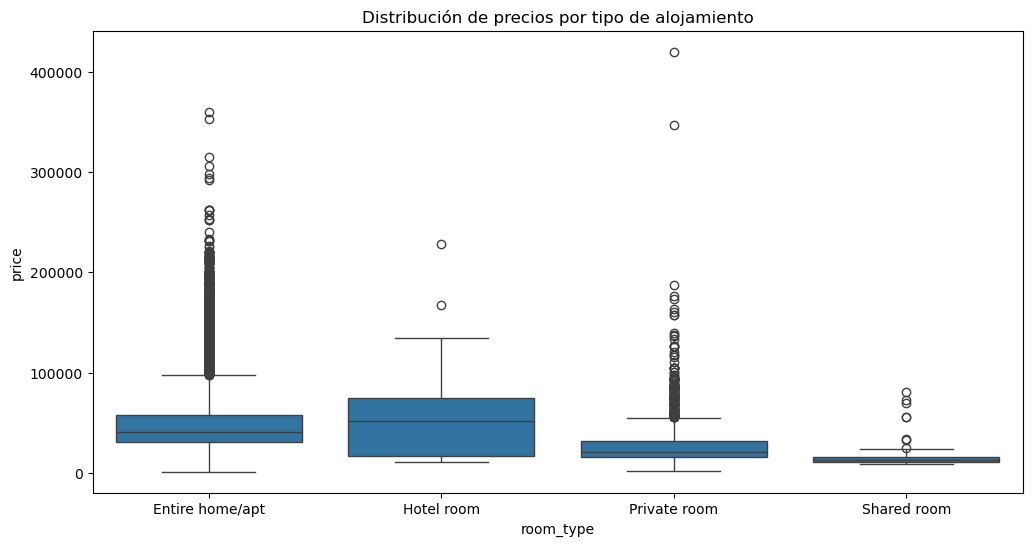

In [152]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=df_fe)
plt.title('Distribución de precios por tipo de alojamiento')
plt.show()

Relación entre 'price' y 'room_type' 

* H0: No hay diferencias en el precio medio entre los distintos tipos de alojamiento
* H1: hay diferencias en el precio medio entre los distintos tipos de alojamiento

In [140]:
from scipy.stats import f_oneway
groups = [df_fe[df_fe['room_type'] == cat]['price'] for cat in df_fe['room_type'].unique()]
f_stat, p = f_oneway(*groups)
print(f"ANOVA - Precio vs Tipo de alojamiento: F={f_stat:.2f}, p={p:.4f}")

if p <= 0.05:
    print("Rechazamos la hipótesis nula: hay diferencias significativas en el precio medio entre los distintos tipos de alojamiento.")
else:
    print("No rechazamos la hipótesis nula: no hay evidencia de que haya diferencias en el precio medio entre los distintos tipos de alojamiento.")

ANOVA - Precio vs Tipo de alojamiento: F=403.65, p=0.0000
Rechazamos la hipótesis nula: hay diferencias significativas en el precio medio entre los distintos tipos de alojamiento.


* ¿Cómo varía la disponibilidad de las propiedades según el número de camas y
habitaciones?

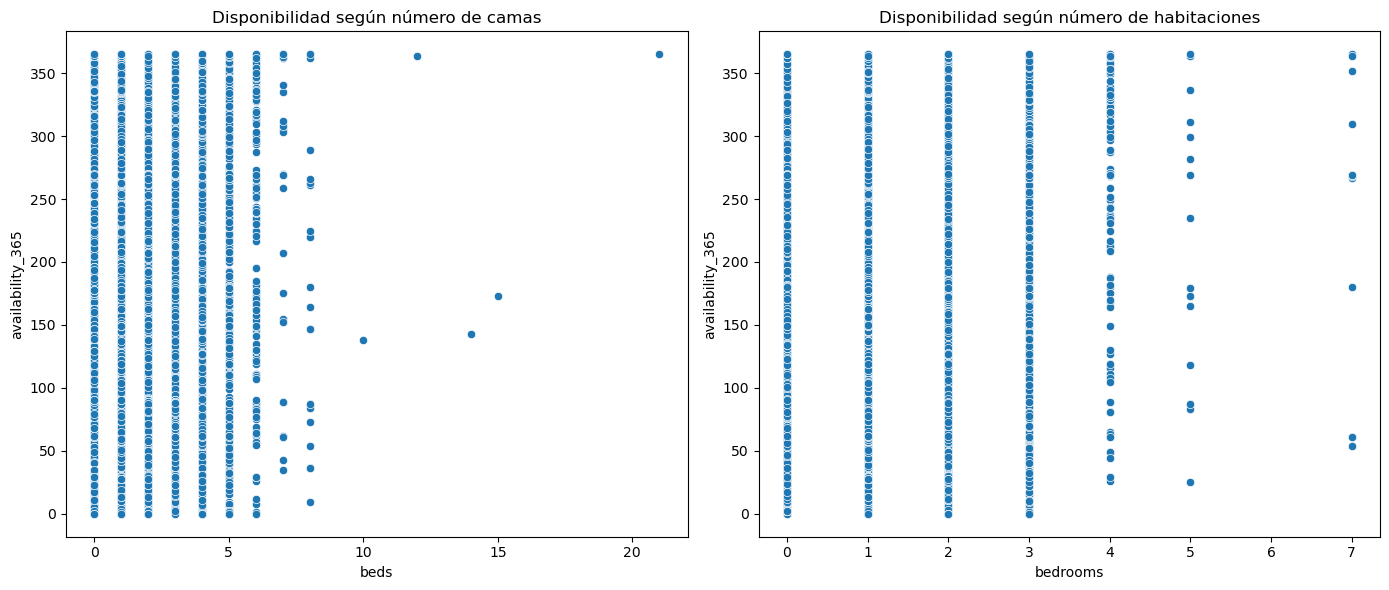

                      beds  bedrooms  availability_365
beds              1.000000  0.507979          0.020168
bedrooms          0.507979  1.000000          0.011266
availability_365  0.020168  0.011266          1.000000

Las correlaciones de beds vs availability_365 y bedrooms vs availability_365 son cercanos a 0, por lo que concluimos
que las camas y habitaciones NO tienen relación directa con la disponibilidad.


In [149]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x='beds', y='availability_365', data=df_fe, ax=axes[0])
axes[0].set_title('Disponibilidad según número de camas')

sns.scatterplot(x='bedrooms', y='availability_365', data=df_fe, ax=axes[1])
axes[1].set_title('Disponibilidad según número de habitaciones')

plt.tight_layout()
plt.show()

# Correlaciones
print(df_fe[['beds', 'bedrooms', 'availability_365']].corr())

print("\nLas correlaciones de beds vs availability_365 y bedrooms vs availability_365 son cercanos a 0, por lo que concluimos" \
"\nque las camas y habitaciones NO tienen relación directa con la disponibilidad.")


* ¿Existen patrones de precios según la ubicación, por ejemplo, en barrios específicos?


neighbourhood_cleansed
Puerto Madero        116976.357527
Versalles             56999.333333
Mataderos             54555.172414
Colegiales            54062.096403
Palermo               53301.399642
Villa Devoto          52648.893204
Nuñez                 50766.696970
Recoleta              50074.069799
Retiro                49758.535593
Belgrano              48226.223642
Villa Santa Rita      45245.346154
Parque Avellaneda     44729.882353
Barracas              44723.778261
San Telmo             41482.947805
San Nicolas           40697.325933
Villa Urquiza         40262.184358
Villa Crespo          40221.689228
Villa Luro            40197.096774
Chacarita             39780.592233
Coghlan               39472.720000
Boca                  39202.894737
Saavedra              38938.899038
Monserrat             38548.906315
Caballito             37602.672662
Villa Pueyrredon      37566.019231
Floresta              37530.931034
Almagro               37314.157559
Parque Chacabuco      36726.3389

C:\Users\josep\AppData\Local\Temp\ipykernel_24336\850050612.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

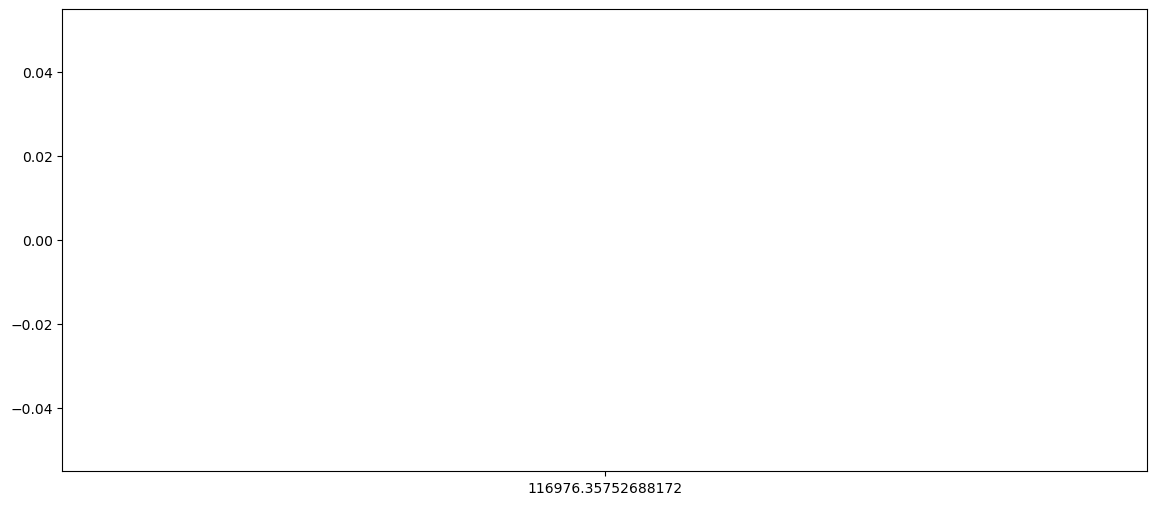

In [ ]:
precio_promedio_barrio = df_fe.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Imprimir el resultado
print(precio_promedio_barrio)

top_neigh = df_fe['neighbourhood_cleansed'].value_counts().nlargest(20).index
df_top = df_fe[df_fe['neighbourhood_cleansed'].isin(top_neigh)]

mean_prices = df_top.groupby('neighbourhood_cleansed')['price'].mean()
df_top['neighbourhood_cleansed'] = pd.Categorical(
    df_top['neighbourhood_cleansed'],
    categories=mean_prices.index,
    ordered=True
)

top10_expensive = mean_prices.sort_values(ascending=False).head(10)
top10_cheap = mean_prices.sort_values().head(10)

selected_neighs = list(top10_expensive.index) + list(top10_cheap.index)
df_selected = df_fe[df_fe['neighbourhood_cleansed'].isin(selected_neighs)].copy()

# Reordenar categorías para que los gráficos se vean ordenados
ordered_neighs = list(top10_expensive.index) + list(top10_cheap.index)
df_selected['neighbourhood_cleansed'] = pd.Categorical(
    df_selected['neighbourhood_cleansed'],
    categories=ordered_neighs,
    ordered=True
)
plt.figure(figsize=(18, 10))

# --- Boxplot: 10 barrios más caros ---
plt.subplot(2, 2, 1)
sns.boxplot(
    x='neighbourhood_cleansed', y='price',
    data=df_selected[df_selected['neighbourhood_cleansed'].isin(top10_expensive.index)]
)
plt.title('Boxplot - Barrios más caros')
plt.xticks(rotation=45)

# --- Boxplot: 10 barrios más baratos ---
plt.subplot(2, 2, 2)
sns.boxplot(
    x='neighbourhood_cleansed', y='price',
    data=df_selected[df_selected['neighbourhood_cleansed'].isin(top10_cheap.index)]
)
plt.title('Boxplot - Barrios más baratos')
plt.xticks(rotation=45)

# --- Barplot: Promedio - más caros ---
plt.subplot(2, 2, 3)
sns.barplot(
    x=top10_expensive.index, y=top10_expensive.values
)
plt.title('Precio promedio - Barrios más caros')
plt.ylabel('Precio promedio')
plt.xticks(rotation=45)

# --- Barplot: Promedio - más baratos ---
plt.subplot(2, 2, 4)
sns.barplot(
    x=top10_cheap.index, y=top10_cheap.values
)
plt.title('Precio promedio - Barrios más baratos')
plt.ylabel('Precio promedio')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* ¿Qué características (número de camas, tipo de propiedad, etc.) están más correlacionadas con la puntuación de los huéspedes?

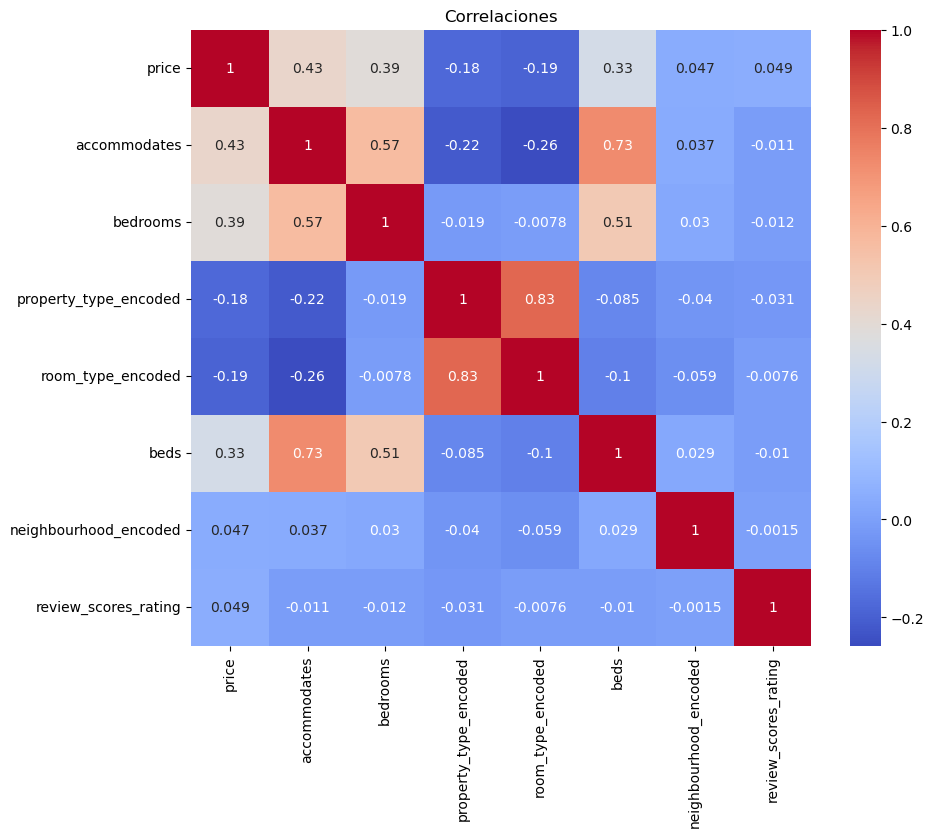

In [143]:
num_cols = [
    'price', 'accommodates', 'bedrooms', 'property_type_encoded', 'room_type_encoded',
    'beds', 'neighbourhood_encoded', 'review_scores_rating'
]

corr_matrix = df_fe[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlaciones')
plt.show()


* ¿Cómo varía la distribución de precios según el tipo de propiedad y el número de
reseñas recibidas?

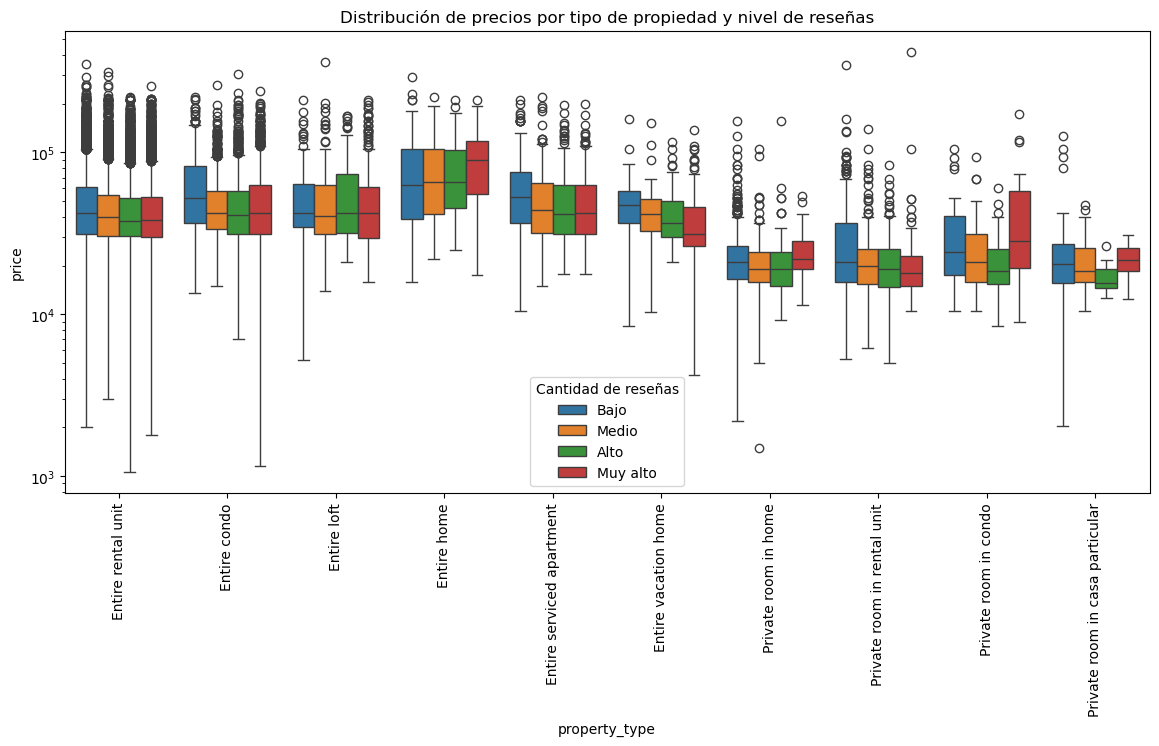

                      property_type reviews_bin  count   median          mean  \
0                      Entire condo        Bajo    492  52285.0  63049.286585   
1                      Entire condo       Medio    649  42009.0  51780.959938   
2                      Entire condo        Alto    967  40958.0  50422.137539   
3                      Entire condo    Muy alto   1127  42460.0  52321.614907   
4                       Entire home        Bajo    130  63013.0  79344.315385   
5                       Entire home       Medio     72  65565.0  79055.416667   
6                       Entire home        Alto     68  65791.0  78005.823529   
7                       Entire home    Muy alto     57  89268.0  90883.140351   
8                       Entire loft        Bajo     96  42161.0  54920.145833   
9                       Entire loft       Medio    116  40360.0  56337.000000   
10                      Entire loft        Alto    169  42009.0  57050.390533   
11                      Enti

C:\Users\josep\AppData\Local\Temp\ipykernel_24336\304492278.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = df_top.groupby(['property_type', 'reviews_bin'])['price'].agg(['count', 'median', 'mean', 'std']).reset_index()


In [144]:
# Seleccionamos los 10 tipos más comunes
top_property_types = df_fe['property_type'].value_counts().nlargest(10).index

# Filtramos el DataFrame
df_top = df_fe[df_fe['property_type'].isin(top_property_types)]


plt.figure(figsize=(14, 6))
sns.boxplot(x='property_type', y='price', hue='reviews_bin', data=df_top)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Distribución de precios por tipo de propiedad y nivel de reseñas')
plt.legend(title='Cantidad de reseñas')
plt.show()

grouped_stats = df_top.groupby(['property_type', 'reviews_bin'])['price'].agg(['count', 'median', 'mean', 'std']).reset_index()
print(grouped_stats.sort_values(by=['property_type', 'reviews_bin'], ascending=True).head(40))

###  3. Inferencia estadística

* ¿Los alojamientos altamente comentados tienen mejor puntaje?

H0: no hay diferencia en la media de review_scores_rating para highly_reviewed = 1 y 0.

H1: hay diferencia entre la media de review_scores_rating para los alojamientos altamente comentados y los que no son tan comentados.

In [145]:
from scipy.stats import ttest_ind

high = df_fe[df_fe['highly_reviewed'] == 1]['review_scores_rating']
low = df_fe[df_fe['highly_reviewed'] == 0]['review_scores_rating']

t_stat, p = ttest_ind(high.dropna(), low.dropna(), equal_var=False)
print(f"T-Test - Puntaje según 'highly_reviewed': t={t_stat:.2f}, p={p:.4f}")

if p <= 0.05:
    print("Rechazamos H0: concluimos que la cantidad de comentarios tiene un impacto en la puntuciación promedio.")
else:
    print("No rechazamos H0: no hay evidencia de que haya diferencias (la cantidad de comentarios no afecta la posición).")

T-Test - Puntaje según 'highly_reviewed': t=14.16, p=0.0000
Rechazamos H0: concluimos que la cantidad de comentarios tiene un impacto en la puntuciación promedio.
